<a href="https://colab.research.google.com/github/Keshav-Sundar-4/RD_ML_Model/blob/main/Gray_Scott_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title Imports

%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from PIL import Image
import time

In [6]:
#@title Seed State + helper functions

def seed_state(N, random_influence=0.2):
    """
    Initialize concentration grids U and V.

    Parameters:
    - N: Grid size (N x N)
    - random_influence: Amount of noise to add

    Returns:
    - U, V: Initialized concentration grids
    """
    U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
        random_influence * np.random.random((N, N)).astype(np.float32)
    V = random_influence * np.random.random((N, N)).astype(np.float32)

    # Add disturbance in the center
    N2 = N // 2
    r = int(N / 10.0)

    U[N2-r:N2+r, N2-r:N2+r] = 0.50
    V[N2-r:N2+r, N2-r:N2+r] = 0.25

    return U, V

def to_rgb(U, V):
    """
    Convert U and V concentration grids to an RGB image.

    Parameters:
    - U, V: Concentration grids

    Returns:
    - image: PIL Image in RGB format
    """
    U_np = U.numpy().squeeze()
    V_np = V.numpy().squeeze()

    # Normalize U and V to [0, 1]
    U_normalized = np.clip(U_np, 0, 1)
    V_normalized = np.clip(V_np, 0, 1)

    # Create RGB channels
    red_channel = (U_normalized * 255).astype(np.uint8)
    green_channel = (V_normalized * 255).astype(np.uint8)
    blue_channel = np.zeros_like(red_channel)

    # Stack channels to create RGB image
    rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    image = Image.fromarray(rgb_image, mode='RGB')
    return image


In [7]:
#@title Paramter Creation

# Parameters
Du = 0.16       # Diffusion coefficient for U
Dv = 0.08       # Diffusion coefficient for V
F = 0.060       # Feed rate
k = 0.062       # Kill rate
dt = 1.0        # Time step size
size = 256      # Grid size (size x size)

# Laplacian kernel for convolution
laplacian_kernel = tf.constant([[0, 1, 0],
                                [1, -4, 1],
                                [0, 1, 0]], dtype=tf.float32)
laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # Shape: [filter_height, filter_width, in_channels, out_channels]

# Initialize U and V
U_init, V_init = seed_state(size)

# Convert to TensorFlow variables and add batch and channel dimensions
U = tf.Variable(tf.expand_dims(tf.expand_dims(U_init, axis=0), axis=-1))  # Shape: [1, size, size, 1]
V = tf.Variable(tf.expand_dims(tf.expand_dims(V_init, axis=0), axis=-1))  # Shape: [1, size, size, 1]




In [8]:
#@title Update Function

@tf.function
def gray_scott_update(U, V, Du, Dv, F, k, dt=1.0):
    """
    Perform one update step of the Gray-Scott model.

    Parameters:
    - U, V: Current concentration grids
    - Du, Dv: Diffusion coefficients
    - F, k: Feed and kill rates
    - dt: Time step size
    """
    # Compute Laplacian using convolution
    laplacian_U = tf.nn.conv2d(U, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')
    laplacian_V = tf.nn.conv2d(V, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')

    # Reaction terms
    UVV = U * V * V

    # Update equations
    dU = Du * laplacian_U - UVV + F * (1 - U)
    dV = Dv * laplacian_V + UVV - (F + k) * V

    # Update concentrations
    U.assign_add(dU * dt)
    V.assign_add(dV * dt)

    # Clip values to maintain stability
    U.assign(tf.clip_by_value(U, 0.0, 1.0))
    V.assign(tf.clip_by_value(V, 0.0, 1.0))

In [9]:
#@title Visualization
def visualize(U, V, step, interval=50):
    """
    Visualize the current state of the simulation.

    Parameters:
    - U, V: Current concentration grids
    - step: Current simulation step
    - interval: Time between frames in seconds
    """
    image = to_rgb(U, V)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Step {step}")
    plt.axis('off')
    plt.show()

    clear_output(wait=True)
    display(image)
    time.sleep(0.01)  # Adjust for desired speed

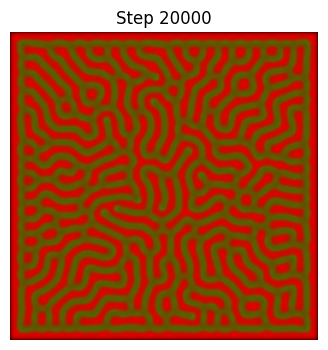

In [12]:
#@title tf simulation

# Number of simulation steps
num_steps = 20000

# Visualization interval (steps between frames)
vis_interval = 500

# Initialize matplotlib figure
plt.figure(figsize=(4,4))

for step in range(1, num_steps + 1):
    gray_scott_update(U, V, Du, Dv, F, k, dt)

    if step % vis_interval == 0:
        # Visualize the current state
        image = to_rgb(U, V)
        plt.imshow(image)
        plt.title(f"Step {step}")
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(0.1)  # Pause to allow the image to render